# Using a pretrained Imagenet network to predict images into one of the 1000 Imagenet classes

**Goal:** In this notebook you will learn how load a pretrained Imagenet network. You will see how you can download iamges from the web and resize it to the corresponding input size of the network. In addition, you will use the orginal preprocessing of the VGG16 network. You will use to the network to classify some images into one of 1000 classes. You will fist use rather clear and obvious examples for a dog (affenpinscher) and an elephant (tusker) and then you will use a quite unusual image of an elephant inside a building from the Smithsonian Museum of Natural History in Washington DC, which the pretrained network probably never saw in that way because it was not part of the Imagenet training dataset. Will the VGG16 network be able to predict the unusual image into the correct class?

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. 

**Content:**
* Load the pretrained VGG16 network that was trained on the 1000 classes of Imagenet
* Download and resize iamges from urls
* Define a function to apply the original preprocessing that the VGG team used when they trained the network
* Define a function to undo the original preprocessing (to be able to plot the image afterwards, if necessary)
* Predict the two clear examples of a dog and an elephant and decode the predictions into the corresponding lables
* Predict the unusual image of the elephant in the museum and decode the predictions into the corresponding lables

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_07/nb_ch07_01.ipynb)


In [1]:
#Execute this cell to be sure to have a compatible TF (2.0) and TFP (0.8) version. 
# If you are bold you can skip this cell. 
try: #If running in colab 
  import google.colab
  !pip install tensorflow==2.0.0
  !pip install tensorflow_probability==0.8.0
except:
  print('Not running in colab')

In [2]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [3]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  True


#### Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from urllib.request import urlopen
from PIL import Image

%matplotlib inline
plt.style.use('default')

print("TF  Version",tf.__version__)


TF  Version 2.0.0


### Loading the pretrained VGG16 network, trained on the large Imagetnet dataset 
In the next cells you download the pretrained VGG16 network, you specify inclide_top = True, because you will use the network for classification and not for feature extraction. The weights = "imagenet" means that you want to use the pretrained weights and not random weights. When you print the model summary, you can see that the network input size is 224x224x3, so you will need to resize the images into that size. The output is 1000 which corresponds to the probabilities for the 1000 classes, in between we have convolution, maxpooling and dense layers.


In [5]:
# The pretrained VGG16 network need quite some memory, 
# make sure you have enough memory allocated for docker if you are running this notebook locally

model_vgg=tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 12s 0us/step


In [6]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In the next cell you define two function to preprocess the input image and to undo the preprocessing. The preprocessing is very simple, it is just substracting the mean value of every channel, the mean values for the channels are calculated on the Imagenet training dataset. Note that we first need to shift the channels around because the VGG team used the BGR and not the RGB format.

In [7]:
def preprocess_input(img):
  x=np.zeros((224,224,3),dtype="float32")
  x[:,:,0]=img[:,:,2]
  x[:,:,1]=img[:,:,1]
  x[:,:,2]=img[:,:,0]
  mean = [103.939, 116.779, 123.68]
  x[:,:, 0] = x[:,:, 0]-mean[0]
  x[:,:, 1] = x[:,:, 1]-mean[1]
  x[:,:, 2] = x[:,:, 2]-mean[2]
  return x 

def undo_preprocess_input(img):
  mean = [103.939, 116.779, 123.68]
  img[:,:, 0] = img[:,:, 0]+mean[0]
  img[:,:, 1] = img[:,:, 1]+mean[1]
  img[:,:, 2] = img[:,:, 2]+mean[2]
  x=np.zeros((224,224,3),dtype="float32")
  x[:,:,0]=img[:,:,2]
  x[:,:,1]=img[:,:,1]
  x[:,:,2]=img[:,:,0]
  return x 

## Loading two clear images of a dog (affenpinscher) and an elephant (tusker)

In the next few cells you will download two images from urls and resize them to the input size of the pretrained VGG16 model which is 224x244x3. You plot them before and after the resizing. As you can see the images are very clear and there should be no problem to classify them into the correct label.



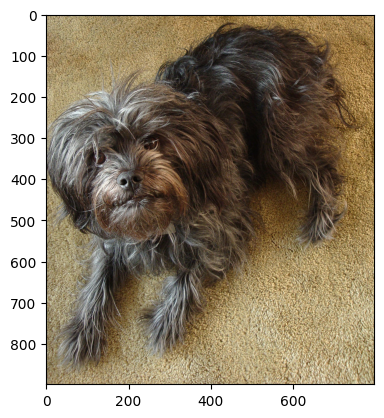

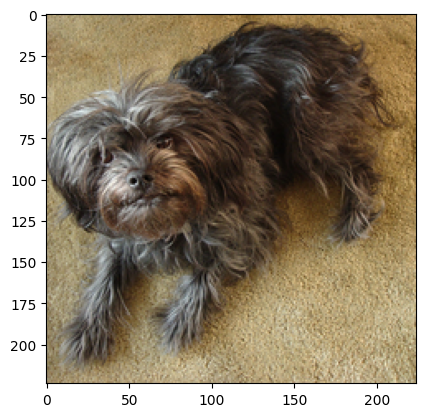

In [8]:
img1 = (Image.open(urlopen("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Affenpinscher_Molly.jpg")))
plt.imshow(img1)
plt.show()
new_width  = 224
new_height = 224
img1 = img1.resize((new_width, new_height), Image.ANTIALIAS)
plt.imshow(img1)
plt.show()
img1=np.array(img1)

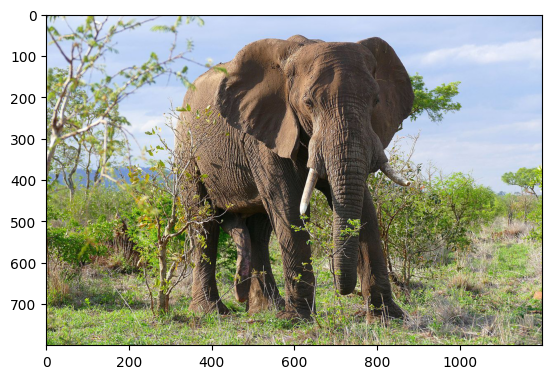

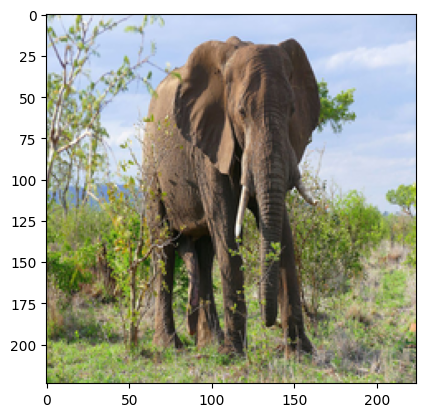

In [9]:
img2 = (Image.open(urlopen("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/African_Elephant.jpg")))
plt.imshow(img2)
plt.show()
new_width  = 224
new_height = 224
img2 = img2.resize((new_width, new_height), Image.ANTIALIAS)
plt.imshow(img2)
plt.show()
img2=np.array(img2)

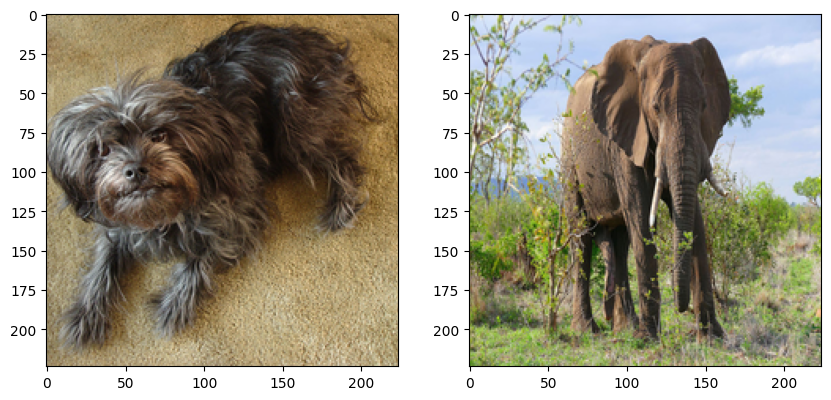

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.savefig("7.ok.pdf")
#from google.colab import files
#files.download('7.ok.pdf') 
#plt.show()

Now that the images are in the right size, let's use the network to predict the label. Don't forget to preprocess the input image before the prediction.

In [11]:
img1=preprocess_input(img1)
print(img1.shape)
img2=preprocess_input(img2)
print(img2.shape)

(224, 224, 3)
(224, 224, 3)


In [12]:
pred1=model_vgg.predict(np.expand_dims(img1,axis=0))
tf.keras.applications.vgg16.decode_predictions(pred1)

40960/35363 [==================================] - 0s 0us/step


[[('n02110627', 'affenpinscher', 0.60996807),
  ('n02094433', 'Yorkshire_terrier', 0.115058616),
  ('n02097474', 'Tibetan_terrier', 0.06349397),
  ('n02086240', 'Shih-Tzu', 0.053632747),
  ('n02098413', 'Lhasa', 0.03696351)]]

In [13]:
pred2=model_vgg.predict(np.expand_dims(img2,axis=0))
tf.keras.applications.vgg16.decode_predictions(pred2)

[[('n01871265', 'tusker', 0.78523684),
  ('n02504458', 'African_elephant', 0.15363279),
  ('n02504013', 'Indian_elephant', 0.061097145),
  ('n02437312', 'Arabian_camel', 6.1530195e-06),
  ('n02109047', 'Great_Dane', 5.6249905e-06)]]

As you can see the network has no problem to predict the correct label, affenpinscher and tusker are there with a high probability.

## Loading and predicting "the elephant in the room" 

Let's see if the VGG16 network is also able to predict an image that was not part of the training dataset, in this case an elephant inside a museum. Note that there are a lot of other objects in the image and the lighting is also not very good. Let's load, resize, preprocess and predict the image.



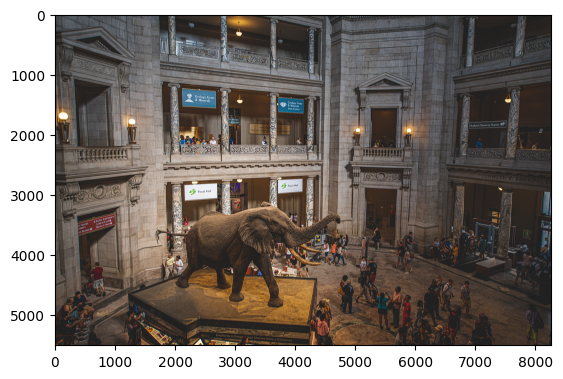

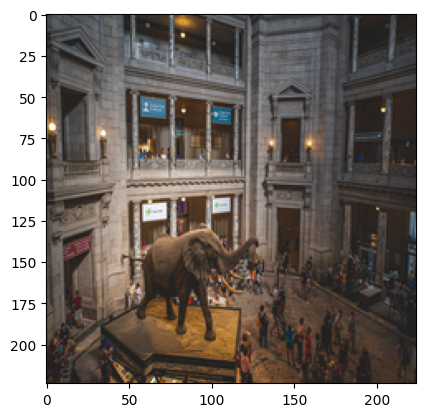

In [14]:
### Image by mana5280 on Unsplash, Smithsonian Museum of Natural History, Washington DC

img = (Image.open(urlopen("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/mana5280-o69yU0jE0Nk-unsplash.jpg")))
plt.imshow(img)
plt.show()
new_width  = 224
new_height = 224
img = img.resize((new_width, new_height), Image.ANTIALIAS)
plt.imshow(img)
plt.show()
img=np.array(img)

In [15]:
img=preprocess_input(img)
print(img.shape)

(224, 224, 3)


In [16]:
pred=model_vgg.predict(np.expand_dims(img,axis=0))
tf.keras.applications.vgg16.decode_predictions(pred)

[[('n03538406', 'horse_cart', 0.4158384),
  ('n04204347', 'shopping_cart', 0.03205152),
  ('n03877845', 'palace', 0.0250339),
  ('n04335435', 'streetcar', 0.025024734),
  ('n03447447', 'gondola', 0.024880113)]]

**You can see that the VGG16 network is not able to predict the elephant in the room (the top prediction is horse cart), even though as a human you have no problem at all to see the elephant! The problem is that this is a quite unusual image and in the Imagenet training dataset there were no elephants inside, they used "normal" images of elephants in free wilderness.**

**This is a principle weakness of deep learning and machine learning in general. We, as humans, obviously learn differently. No child in the world would not see the elephant in this image once she learned what an elephant looks like.**
